In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from epytox import guts
from epytox import exposure

sns.set(rc={"figure.figsize": (8, 6)}, 
        font_scale=1.5, style='white', context='notebook')

,Control,Treatment 1,Treatment 2
Time (days),,,
0.00,0,27.625754,16.532655
1.00,0,28.294151,16.460963
1.01,0,0.000000,0.000000
2.00,0,0.163600,0.094863
3.00,0,0.186772,0.000000


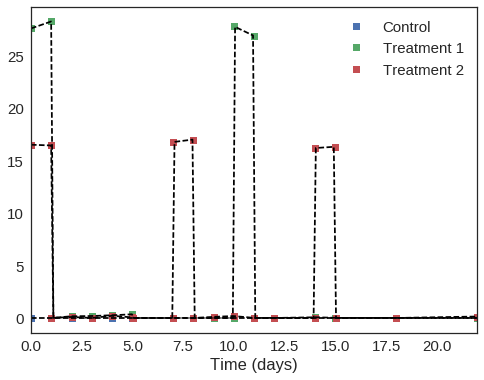

In [2]:
#Load exposure data and create interpolating functions
exposure_data = pd.read_excel('../data/carbaryl.xlsx', sheetname='Exposure', index_col=0)

exposure_funcs = exposure.multi_interp_treatment_generator(exposure_data)
times = np.linspace(exposure_data.index[0], exposure_data.index[-1], 200)

ax = exposure_data.plot(marker='s', ls='')

for treat, f in exposure_funcs.items():
    ax.plot(times, f(times), 'k--')
    
exposure_data.head()

,Control,Treatment 1,Treatment 2
Time (days),,,
0,60,60,60
1,57,59,58
2,57,50,54
3,57,46,54
4,57,44,54


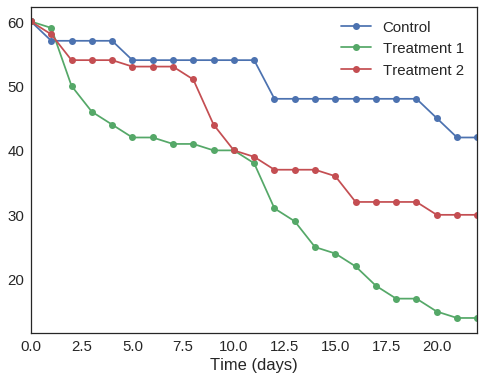

In [3]:
#Load survival data
survival_data = pd.read_excel('../data/carbaryl.xlsx', sheetname='Survival', index_col=0)
survival_data.plot(marker='o')
survival_data.head()

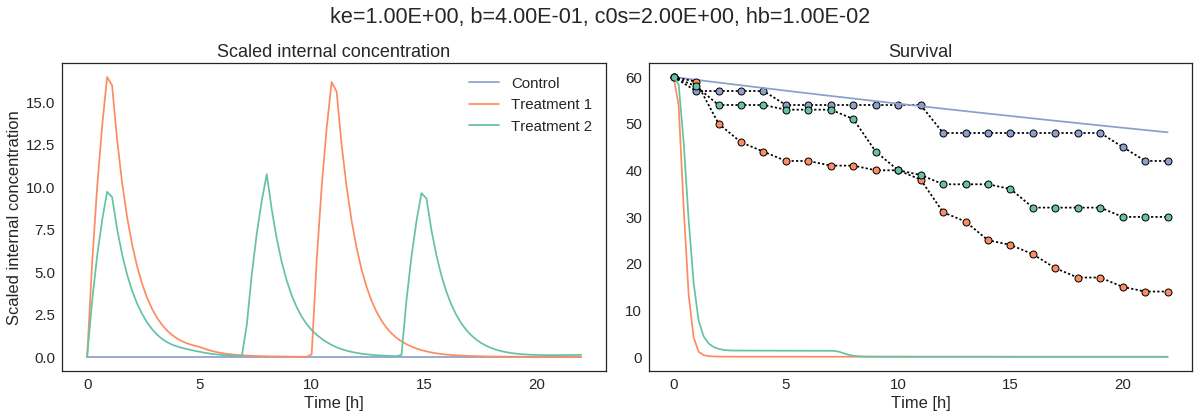

In [4]:
guts_sic_sd = guts.SIC_SD()
fig, ax = guts.plot_fit(guts_sic_sd, survival_data, exposure_funcs, subplots=False)

In [5]:
datasets = [(exposure_funcs[treat], survival_data[treat]) for treat in survival_data.columns]

  0%|          | 2/3000 [00:00<04:01, 12.42it/s]

Parameters([('ke', <Parameter 'ke', 1.0, bounds=[1e-10:100.0]>), ('b', <Parameter 'b', 0.4, bounds=[1e-10:100]>), ('c0s', <Parameter 'c0s', 2.0, bounds=[1e-10:100]>), ('hb', <Parameter 'hb', 0.01, bounds=[0:10]>)])


 17%|█▋        | 498/3000 [00:41<03:30, 11.89it/s]


Optimization terminated successfully.
[[Fit Statistics]]
    # function evals   = 498
    # data points      = 1
    # variables        = 4
    chi-square         = 143830.900
    reduced chi-square = -47943.633
    Akaike info crit   = 19.876
    Bayesian info crit = 11.876
[[Variables]]
    ke:    0.13134754 (init= 1)
    b:     0.06053008 (init= 0.4)
    c0s:   1.60993968 (init= 2)
    hb:    0.01440137 (init= 0.01)
[[Correlations]] (unreported correlations are <  0.100)
CPU times: user 37.8 s, sys: 3.21 s, total: 41 s
Wall time: 41.9 s


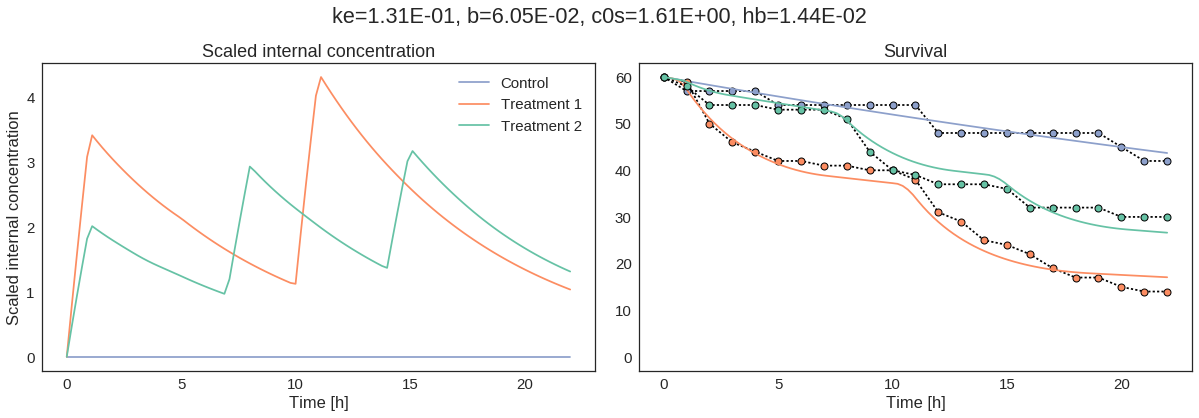

In [6]:
# Fit model by minimizing negative log likelihood function
guts_sic_sd = guts.SIC_SD()
print(guts_sic_sd.params)
%time res = guts_sic_sd.fit(datasets)
guts_sic_sd.params = res.params
fig, ax = guts.plot_fit(guts_sic_sd, survival_data, exposure_funcs, subplots=False)

In [7]:
#Sample posterior with emcee
%time mcmcres = guts_sic_sd.mcmc(datasets, nwalkers=10, nsteps=1000)

  0%|          | 3/10000 [00:00<07:05, 23.47it/s]

Commencing MCMC with 10 walkers, 1000 steps


 96%|█████████▋| 9649/10000 [10:11<00:22, 15.78it/s]

CPU times: user 9min 17s, sys: 59.4 s, total: 10min 17s
Wall time: 10min 11s


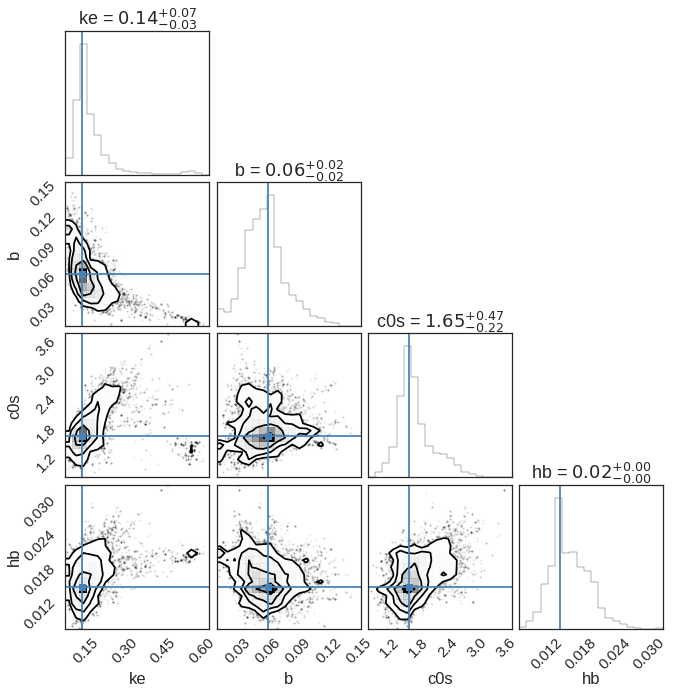

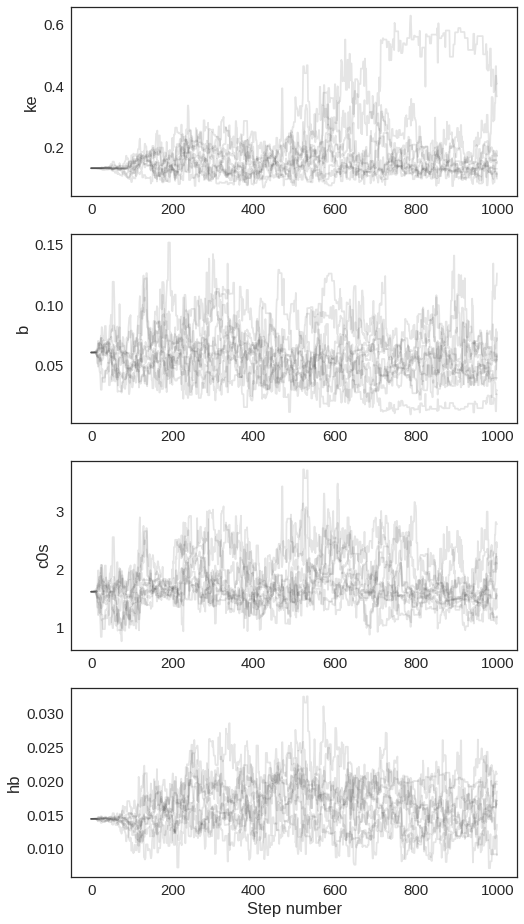

In [8]:
#Plot mcmc results
fig, ax, c = guts.plot_mcmc(mcmcres, guts_sic_sd.mle_result)